In [71]:
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyfits as fits
from scipy.stats import norm

In [72]:
docompute = True

In [152]:
def read_muse(filename):
    data = fits.open(filename)
    cube = data[1].data
    header = data[1].header
    ecube = data[2].data
    #  -- get wave
    CRVAL = float(header["CRVAL3"])
    NAXIS = int(header["NAXIS3"])
    CDELT = float(header["CD3_3"])
    CRPIX = float(header["CRPIX3"])
    wave = np.array(CRVAL + CDELT * (np.arange(NAXIS) - CRPIX))
    return wave,cube,np.sqrt(ecube)

/home/apps/astro/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt


10.8111085796 15.0137771416


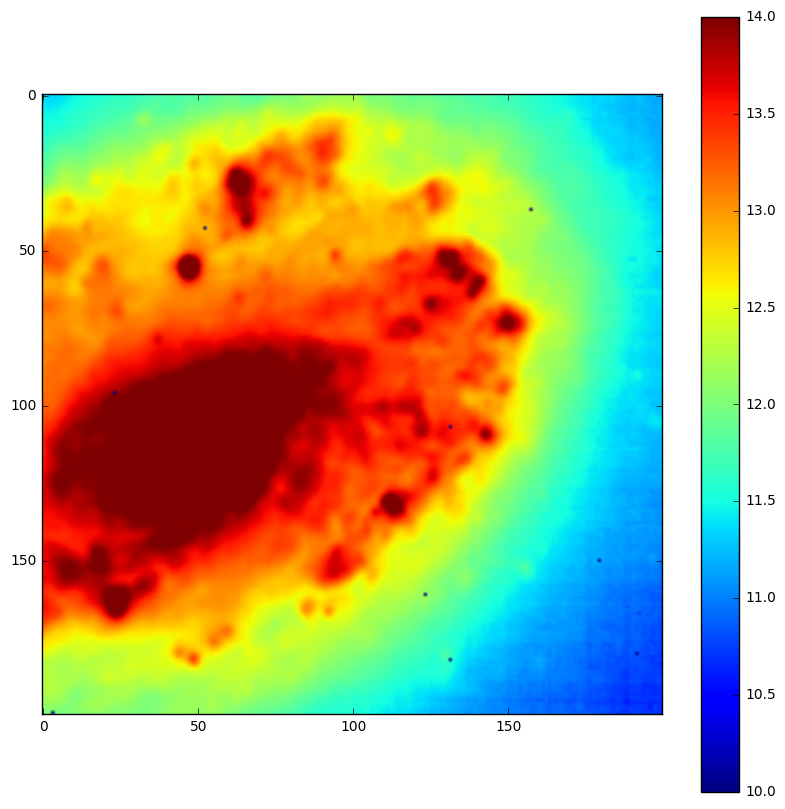

In [153]:
#filename = "muse_scipost_N_ASASSN14lp_1_new_DATACUBE_FINAL_IFU_004_zap_all.fits"
dir = '/home/apps/astro/data/muse/'
filename = "muse_scipost_N_SN2009bb_DATACUBE_FINAL_IFU_001_zap.fits"
#filename = "muse_scipost_N_SN2004ef_DATACUBE_FINAL_IFU_002_skysub.fits"
wave,cube,ecube=read_muse(dir+filename)
#image = image[:, 63:263, 100:300]
image = cube[:, 100:300, 20:220]
eimage = ecube[:, 100:300, 20:220]
(nl, nx, ny) = np.shape(image)
image2D = np.sum(image, axis = 0)
image2D[np.invert(np.isfinite(image2D))] = 0
image2D = np.arcsinh(image2D)
fig, ax = plt.subplots(figsize = (10, 10))
l1, l2 = (np.percentile(image2D.flatten(), 1), np.percentile(image2D.flatten(), 99))
print(l1, l2)
color = ax.imshow(image2D, clim = (10, 14));
fig.colorbar(color)


In [76]:
## GAUSS+LINE FUNCTION
def gaussline(pars,x):
    a,b,c,m,i=pars
    return a*np.exp(-(x-b)**2/(2*c)**2)+m*x+i

## FCT TO FIT GAUSSIAN+LINE
#       fitter: kmpfit' or 'emcee'
def fit_gaussline(wave,flux,eflux,restwave,wavebin=15.0,fitter='kmpfit'):
    fct = lambda p,data: (data[1]-gaussline(p,data[0]))**2/data[2]**2
    p0=np.array([1.0,restwave,0.1,0.0,0.2])
    fitobj = kmpfit.Fitter(residuals=fct, data=(wave,flux,eflux))
    fitobj.parinfo=[{'limits':[0,None]},{'limits':[restwave-wavebin,restwave+wavebin]},{},{},{}]
    fitobj.fit(params0=p0)
    pars,ers=fitobj.params,fitobj.stderr#xerror
    if fitter == 'emcee':
        ndim, nwalkers = 5, 100
        pos = [pars + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lngaussline, args=(wave,flux,eflux))
        sampler.run_mcmc(pos, 500)
        samples = sampler.chain[:, 200:, :].reshape((-1, ndim)) #flatten chain after 200 steps
        pars=np.median(samples,0)                               #median
        ers=robust.mad(samples,axis=0)                          #mad
    return pars,ers

In [129]:
points = np.random.randint(200, size=(100, 2))
x_ = np.array([i for i in range(100)])

In [162]:
print(ecube.shape)
print(cube.shape)
len(cube == np.NaN)

(3681, 321, 320)
(3681, 321, 320)


3681

In [217]:
def neigh_data(flux, n, i_max):
    left_n = flux[i_max + 1: i_max + n + 1]
    left_r = flux[i_max - n: i_max]
    neigh = np.hstack((left_n, left_r))
    n_std = np.std(neigh)
    n_mean = np.mean(neigh)
    return n_std, n_mean, np.amax(flux)

In [232]:
from kapteyn import kmpfit
ha_bin,gha_bin=15.0,50.0
c=299792.458

ha_list=np.zeros((ndim[1],ndim[2]))*np.nan
ndim=np.shape(cube)
for i in range(1,ndim[1]):
    for j in range(1,ndim[2]):
        flux,eflux=cube[:,i,j], ecube[:,i,j]
        
        peak_i = np.argmax(flux)
        std, mean, peak = neigh_data(flux, 10, peak_i)
        
        if peak > mean + 5 * std:
            ha_wave = wave[peak_i]
            ha_in=np.array(np.where((wave > ha_wave-ha_bin) & (wave < ha_wave+ha_bin) \
                                    & (np.isfinite(flux)) & (np.isfinite(eflux)))).reshape(-1)
            if len(ha_in) < 7: continue
            fmax = np.amax(flux[ha_in])
            pars,erpars = fit_gaussline(wave[ha_in],flux[ha_in]/fmax,eflux[ha_in]/fmax,ha_wave,wavebin=ha_bin)
            #pars,erpars=fit_gaussline(wave[ha_in],flux[ha_in]/fmax,eflux[ha_in]/fmax,ha_wave,wavebin=ha_bin)
            ha_list[i,j] = pars[1]



In [251]:
maybe_work = ha_list

In [252]:
maybe_work

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [249]:
widths = np.array([abs(i) for i in widths])
width = .05